In [41]:
# COMP 551, Fall 2024, McGill University
# Assignment 3
# Rob Li, Ian McFarland, Finnley Howald
# 18 November 2024

In [42]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt

In [43]:
##### Task 1: Acquire the data

In [44]:
# pip install medmnist

In [45]:
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from medmnist import OrganAMNIST

import matplotlib.pyplot as plt

In [46]:
### 1.1. Loading the dataset
raw_dataset = OrganAMNIST(split="train", download=True)

Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz


In [47]:
### 1.2. Checking dataset structure
print("Dataset Structure:")
print(f"Type: {type(raw_dataset)}")
print(f"Length: {len(raw_dataset)}")
print(f"Sample structure: {raw_dataset[0]}")

Dataset Structure:
Type: <class 'medmnist.dataset.OrganAMNIST'>
Length: 34561
Sample structure: (<PIL.Image.Image image mode=L size=28x28 at 0x21B3572F1A0>, array([6]))


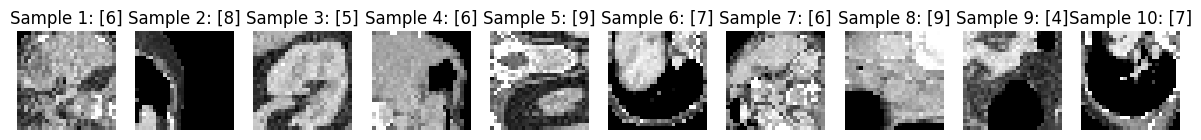

In [48]:
def show_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 7))
    for i in range(num_samples):
        image, label = dataset[i]  # Unpack the data (image and label)
        axes[i].imshow(image, cmap="gray")  # Display the image
        axes[i].set_title(f"Sample {i+1}: {label}")  # Display the label
        axes[i].axis("off")  # Hide axis for better view
    plt.show()

# Show 5 samples from the training dataset
show_samples(raw_dataset)

In [49]:
def mean_var_calc(tr="train"):
  transform = transforms.Compose([transforms.ToTensor()])
  data = OrganAMNIST(split=tr, download=True, transform=transform)
  loader = DataLoader(data, batch_size=1000, shuffle=False) # We could not pass the already loaded dataloader as transform will be different
  sum = 0.0
  squared_sum = 0.0
  N = 0
  for data, _ in loader: # Accumulative sum and std throughout data
    sum += data.sum(dim=[0, 2, 3])
    squared_sum += (data ** 2).sum(dim=[0, 2, 3])
    N += data.numel()
  mean = sum / N
  std = torch.sqrt((squared_sum / N) - (mean ** 2))
  return mean.item(), std.item()

In [50]:
train_mean, train_std = mean_var_calc()
test_mean, test_std = mean_var_calc("test")

Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz


In [51]:
print(train_mean, train_std)
print(test_mean, test_std)

0.4680282771587372 0.297420859336853
0.46014639735221863 0.2833701968193054


In [52]:
### 1.3. Loading the dataset as a flattened and normalized vector
transform_train = transforms.Compose([
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Normalize(mean=train_mean, std=train_std),
    transforms.Lambda(lambda x: x.view(-1))      # Flatten the 28x28 image to 784
])

transform_test = transforms.Compose([
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Normalize(mean=test_mean, std=test_std),
    transforms.Lambda(lambda x: x.view(-1))      # Flatten the 28x28 image to 784
])

# Load dataset with transformations applied
train_dataset = medmnist.dataset.OrganAMNIST(split="train", download=True, transform=transform_train)
test_dataset = medmnist.dataset.OrganAMNIST(split="test", download=True, transform=transform_test)

# Create a DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check a batch to ensure transformations are applied correctly
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")  # Expected shape: [batch_size, 784]
print(f"Batch of labels shape: {labels.shape}")

Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Batch of images shape: torch.Size([64, 784])
Batch of labels shape: torch.Size([64, 1])


In [53]:
X_train, Y_train = [], []
X_test, Y_test = [], []
for images, labels in train_loader:
  X_train.append(images.numpy())
  Y_train.append(labels.numpy())
for images, labels in test_loader:
  X_test.append(images.numpy())
  Y_test.append(labels.numpy())
X_train = np.concatenate(X_train, axis=0)
Y_train = np.concatenate(Y_train, axis=0).squeeze()  # squeeze to remove extra dimension if needed
X_test = np.concatenate(X_test, axis=0)
Y_test = np.concatenate(Y_test, axis=0).squeeze()
def one_hot_encode(y, num_classes=11):
  one_hot = np.zeros((y.size, num_classes))
  one_hot[np.arange(y.size), y] = 1
  return one_hot
Y_train_encoded = one_hot_encode(Y_train)
Y_test_encoded = one_hot_encode(Y_test)
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_train_encoded shape: {Y_train_encoded.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"Y_test_encoded shape: {Y_test_encoded.shape}")
# Y encoded is for training purposes in the fit function
# Use Y raw for accuracy evalation and testing as the model's final prediction is just the class number

X_train shape: (34561, 784)
Y_train shape: (34561,)
Y_train_encoded shape: (34561, 11)
X_test shape: (17778, 784)
Y_test shape: (17778,)
Y_test_encoded shape: (17778, 11)


In [54]:
# acost perry for
# min max vs real mean var
# random seed

In [184]:
# Activation function library
def softmax(z):
  exps = np.exp(z)
  return exps / np.sum(exps, axis=1, keepdims=True)

class ActivationFunction:
    def function(self, x):
        raise NotImplementedError("Function method not implemented.")

    def derivative(self, x):
        raise NotImplementedError("Derivative method not implemented.")

class ReLU(ActivationFunction):
    def function(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return np.where(x > 0, 1, 0)
    
class LeakyReLU(ActivationFunction):
    def function(self, x):
        return np.where(x > 0, x, x * 0.01)
    def derivative(self, x):
        return np.where(x > 0, 1, 0.01)

class Sigmoid(ActivationFunction):
    def function(self, x):
        return 1 / (1 + np.exp(-x))

    def derivative(self, x):
        sig = self.function(x)
        return sig * (1 - sig)

class Tanh(ActivationFunction):
    def function(self, x):
        return np.tanh(x)

    def derivative(self, x):
        return 1 - np.tanh(x) ** 2
    
logistic = lambda z: 1./ (1 + np.exp(-z))


In [178]:
##### Task 2: Implement a Multilayer Perceptron
class MultilayerPerceptron:

  def __init__(self, activation_function = ReLU, hidden_layers = 2, hidden_layer_widths = [64,64], input_width = 784, output_width = 11):
    if (len(hidden_layer_widths) != hidden_layers):
      raise ValueError("Number of hidden layers does not match the size of layer_widths in MultilayerPerceptron initalization")
    
    self.activation_function = activation_function
    layer_sizes = [input_width] + hidden_layer_widths + [output_width]
    self.weights = []
    self.biases = []

    for i in range (len(layer_sizes) - 1):
      weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
      self.weights.append(weight_matrix)
      bias_vector = np.zeros((1, layer_sizes[i + 1]))
      self.biases.append(bias_vector)

  def fit(self, X, Y, learning_rate = 0.01, epochs = 1e4, batch_size = 32):
    N, D = X.shape

    for epoch in range(epochs):

      # Batch splitting
      indicies = np.arange(N)
      np.random.shuffle(indicies)
      X = X[indicies]
      Y = Y[indicies]

      for index in range(0, N, batch_size):
        X_batch = X[index:index+batch_size]
        Y_batch = Y[index:index+batch_size]

        # Activations
        activations = [X_batch]
        Z_values = []

        # Forward Pass
        for j in range(len(self.weights)):
          Z = np.dot(activations[-1], self.weights[j]) + self.biases[j]
          Z_values.append(Z)

          if j < len(self.weights) - 1: # Hidden Layers 
            A = self.activation_function.function(self, Z)
            
          else: # Output Layer
            A = softmax(Z)

          activations.append(A)

        # Backward Pass
        dLdAj = activations[-1] - Y_batch  # For Loss partial with softmax simplified under cross-entropy (yhat - y)

        if len(self.weights) == 1: 
          for j in reversed(range(len(self.weights))):
            dLdZj = dLdAj
            dLdWj = np.dot(activations[j].T, dLdZj) / batch_size # Partial of Loss w/resp to weight at layer j Wj
            dLdBj = np.sum(dLdZj, axis=0, keepdims=True) / batch_size # Partial of Loss w/resp to Bias at j Bj
            # Update weights and biases
            self.weights[j] -= learning_rate * dLdWj
            self.biases[j] -= learning_rate * dLdBj
        
        else: 
          for j in reversed(range(1, len(self.weights))):
            dLdZj = dLdAj
            
            dLdWj = np.dot(activations[j].T, dLdZj) / batch_size # Partial of Loss w/resp to weight at layer j Wj
            dLdBj = np.sum(dLdZj, axis=0, keepdims=True) / batch_size # Partial of Loss w/resp to Bias at j Bj
            
            if j > 0:
              dLdAj = np.dot(dLdZj, self.weights[j].T) * self.activation_function.derivative(self, Z_values[j-1]) # Partial of Loss w/resp to activation at j Aj

            # Update weights and biases
            self.weights[j] -= learning_rate * dLdWj
            self.biases[j] -= learning_rate * dLdBj

    return self

  def predict(self, X):
    A = X

    for j in range(len(self.weights)):
      Z = np.dot(A, self.weights[j]) + self.biases[j]

      if j < len(self.weights) - 1:
        A = self.activation_function.function(self, Z)

      else:
        A = softmax(Z)

    return np.argmax(A, axis=1)


In [ ]:
class MLP:
    
    def __init__(self, M = 64):
        self.M = M
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v, w = params
            z = logistic(np.dot(x, v)) #N x M
            yh = logistic(np.dot(z, w))#N
            dy = yh - y #N
            dw = np.dot(z.T, dy)/N #M
            dz = np.outer(dy, w) #N x M
            dv = np.dot(x.T, dz * z * (1 - z))/N #D x M
            dparams = [dv, dw]
            return dparams
        
        w = np.random.randn(self.M) * .01
        v = np.random.randn(D,self.M) * .01
        params0 = [v,w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v, w = self.params
        z = logistic(np.dot(x, v)) #N x M
        yh = logistic(np.dot(z, w))#N
        return yh
    
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params


In [57]:
def evaluate_acc(y, y_hat):
  if len(y) != len(y_hat):
    raise ValueError("Size mismatch: y and y_hat must have the same length in evaluate_acc.")
  # Calculate the mean of correct predictions
  accuracy = np.mean(y == y_hat)
  return accuracy * 100

In [181]:
# 3.1 

# MLP no hidden layers

mlp = MultilayerPerceptron(hidden_layers=0, hidden_layer_widths=[])
mlp.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat = mlp.predict(X_test)
accuracy = evaluate_acc(Y_test, Y_hat)
print(accuracy)

# MLP 1 hidden layer, 256 and ReLU
mlp2 = MultilayerPerceptron(hidden_layers=1, hidden_layer_widths=[256])
mlp2.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat2 = mlp2.predict(X_test)
accuracy2 = evaluate_acc(Y_test, Y_hat2)
print(accuracy2)

# MLP 2 hidden layers, 256 and ReLU
mlp3 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256])
mlp3.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat3 = mlp3.predict(X_test)
accuracy3 = evaluate_acc(Y_test, Y_hat3)
print(accuracy3)

58.3698953763078
66.85228934638316
71.12161097986275


In [185]:
# 3.2: 2 Layer MLPs, now using TanH and Leaky ReLU
mlp4 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], activation_function=Tanh)
mlp4.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat4 = mlp4.predict(X_test)
accuracy4 = evaluate_acc(Y_test, Y_hat4)
print(accuracy4)

mlp5 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], activation_function=LeakyReLU)
mlp5.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat5 = mlp5.predict(X_test)
accuracy5 = evaluate_acc(Y_test, Y_hat5)
print(accuracy5)


71.33535830802114
71.68410394870064
